In [6]:
from trajlib.data_processing.data_reader import read_porto_csv

traj_data = read_porto_csv(csv_filepath=r".\resource\dataset\Porto\porto_sample.csv", row_limit=1)
traj_data.point_table

1it [00:00, ?it/s]


,point_id,timestamp,traj_id,lon,lat
0,0,1372636858000000000,1372636858620000589,-8.618643,41.141412
1,1,1372636873000000000,1372636858620000589,-8.618499,41.141376
2,2,1372636888000000000,1372636858620000589,-8.620326,41.142510
3,3,1372636903000000000,1372636858620000589,-8.622153,41.143815
4,4,1372636918000000000,1372636858620000589,-8.623953,41.144373
5,5,1372636933000000000,1372636858620000589,-8.626680,41.144778
6,6,1372636948000000000,1372636858620000589,-8.627373,41.144697
7,7,1372636963000000000,1372636858620000589,-8.630226,41.145210
8,8,1372636978000000000,1372636858620000589,-8.632746,41.146920
9,9,1372636993000000000,1372636858620000589,-8.631738,41.148225


In [7]:
trajectory = [(lon, lat) for lon, lat in traj_data.point_table[["lon", "lat"]].values]
trajectory

[(-8.618643, 41.141412),
 (-8.618499, 41.141376),
 (-8.620326, 41.14251),
 (-8.622153, 41.143815),
 (-8.623953, 41.144373),
 (-8.62668, 41.144778),
 (-8.627373, 41.144697),
 (-8.630226, 41.14521),
 (-8.632746, 41.14692),
 (-8.631738, 41.148225),
 (-8.629938, 41.150385),
 (-8.62911, 41.151213),
 (-8.629128, 41.15124),
 (-8.628786, 41.152203),
 (-8.628687, 41.152374),
 (-8.628759, 41.152518),
 (-8.630838, 41.15268),
 (-8.632323, 41.153022),
 (-8.631144, 41.154489),
 (-8.630829, 41.154507),
 (-8.630829, 41.154516),
 (-8.630829, 41.154498),
 (-8.630838, 41.154489)]

In [8]:
import matplotlib.pyplot as plt

def vis_traj(trajectory, mask=None):
    # 提取x和y坐标
    x_coords = [point[0] for point in trajectory]
    y_coords = [point[1] for point in trajectory]

    # 绘制轨迹
    plt.plot(x_coords, y_coords, linestyle='-')

    if mask is not None:
        # 分别绘制被保留（True）和未被保留（False）的点
        red_x = [x for x, m in zip(x_coords, mask) if m]
        red_y = [y for y, m in zip(y_coords, mask) if m]
        blue_x = [x for x, m in zip(x_coords, mask) if not m]
        blue_y = [y for y, m in zip(y_coords, mask) if not m]

        # 绘制红色（被保留）的点
        plt.scatter(red_x, red_y, color='red')
        # 绘制蓝色（未被保留）的点
        if blue_x and blue_y:  # 避免绘制空列表时报错
            plt.scatter(blue_x, blue_y, color='blue', s=2)
        plt.legend()
    else:
        # 如果没有提供mask，正常绘制所有点
        plt.scatter(x_coords, y_coords, color='blue')

    # 设置图表标题和坐标轴标签
    plt.title('Trajectory Plot')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')

    # 显示图表
    plt.show()

# Trajectory Simplification / Segmentation

## DP Algorithm

In [9]:
def douglas_peucker(points, epsilon=0.001):
    """
    Douglas-Peucker算法实现轨迹压缩

    :param points: 输入的轨迹点列表，每个点是一个二元组 (x, y)
    :param epsilon: 距离阈值，用于控制压缩程度
    :return: 压缩后的轨迹点列表，以及一个和原来输入轨迹一样长度的布尔数组
    """
    # 初始化布尔数组，全部设为 False
    mask = [False] * len(points)

    def dp_recursive(start_index, end_index):
        # 找到距离直线最远的点
        dmax = 0
        index = 0
        for i in range(start_index + 1, end_index):
            d = perpendicular_distance(
                points[i], points[start_index], points[end_index]
            )
            if d > dmax:
                index = i
                dmax = d

        # 如果最远点距离大于阈值，则递归处理
        if dmax > epsilon:
            # 递归处理左侧部分
            dp_recursive(start_index, index)
            # 递归处理右侧部分
            dp_recursive(index, end_index)
        else:
            # 如果最远点距离小于阈值，则只保留起始点和结束点
            mask[start_index] = True
            mask[end_index] = True

    # 处理整个轨迹
    dp_recursive(0, len(points) - 1)

    # 生成压缩后的轨迹点列表
    compressed_points = [points[i] for i in range(len(points)) if mask[i]]

    return compressed_points, mask


def perpendicular_distance(point, start, end):
    """

    计算点到直线的垂直距离


    :param point: 要计算距离的点，二元组 (x, y)

    :param start: 直线的起始点，二元组 (x, y)

    :param end: 直线的结束点，二元组 (x, y)

    :return: 点到直线的垂直距离

    """

    if start == end:

        return distance(point, start)

    else:

        n = abs(
            (end[0] - start[0]) * (start[1] - point[1])
            - (start[0] - point[0]) * (end[1] - start[1])
        )

        d = distance(start, end)

        return n / d


def distance(point1, point2):
    """

    计算两点之间的欧几里得距离


    :param point1: 第一个点，二元组 (x, y)

    :param point2: 第二个点，二元组 (x, y)

    :return: 两点之间的欧几里得距离

    """

    return ((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2) ** 0.5

[True, False, False, False, False, False, False, False, True, False, False, False, False, False, True, False, False, True, False, False, False, False, True]


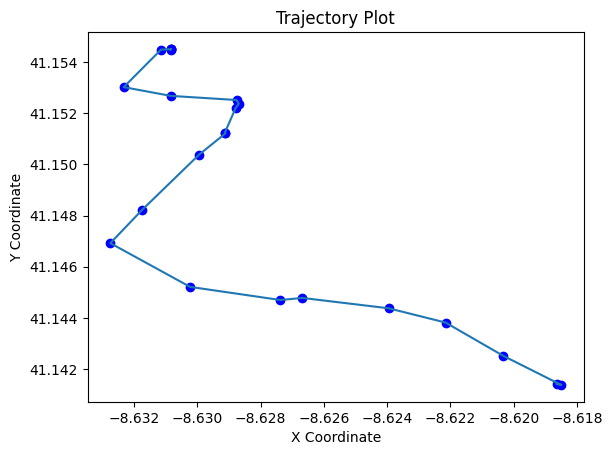

C:\Users\A1495\AppData\Local\Temp\ipykernel_62500\2564276038.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


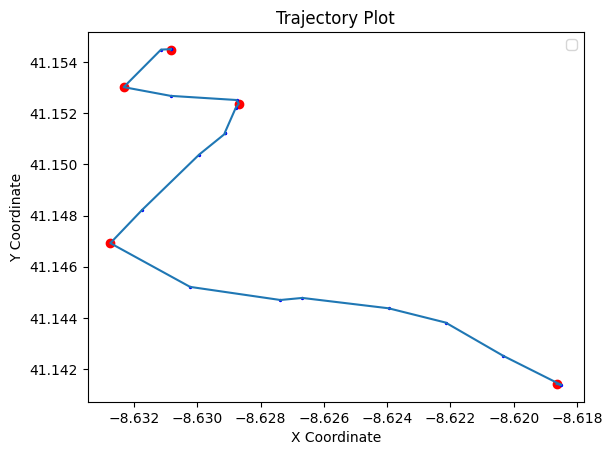

[True, False, False, False, False, False, False, False, True, False, False, False, False, False, True, False, False, True, False, False, False, False, True]


In [10]:
# 调用Douglas-Peucker算法进行轨迹压缩
epsilon = 0.001  # 距离阈值
compressed_trajectory, mask = douglas_peucker(trajectory, epsilon)
print(mask)
# 输出压缩后的轨迹点列表
vis_traj(trajectory)
vis_traj(trajectory, mask=mask)
print(mask)

## TraCLUS cutting

In [5]:
import numpy as np


def d_euclidean(p1, p2):
    """
    Calculate the Euclidean distance between two points.
    """
    return np.sqrt((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2)


def get_point_projection_on_line(point, line):
    """
    Calculate the projection of a point onto a line.
    """
    line_vector = line[1] - line[0]
    point_vector = point - line[0]
    dot_product = np.dot(point_vector, line_vector)
    line_length_squared = np.dot(line_vector, line_vector)
    projection = line[0] + (dot_product / line_length_squared) * line_vector
    return projection


def d_perpendicular(l1, l2):
    """
    Calculate the perpendicular distance between two lines.
    """
    # Find the shorter line and assign that as l_shorter
    l_shorter = l_longer = None
    l1_len, l2_len = d_euclidean(l1[0], l1[-1]), d_euclidean(l2[0], l2[-1])
    if l1_len < l2_len:
        l_shorter = l1
        l_longer = l2
    else:
        l_shorter = l2
        l_longer = l1

    ps = get_point_projection_on_line(l_shorter[0], l_longer)
    pe = get_point_projection_on_line(l_shorter[-1], l_longer)

    lehmer_1 = d_euclidean(l_shorter[0], ps)
    lehmer_2 = d_euclidean(l_shorter[-1], pe)

    if lehmer_1 == 0 and lehmer_2 == 0:
        return 0
    return (lehmer_1**2 + lehmer_2**2) / (lehmer_1 + lehmer_2)


def d_parallel(l1, l2):
    """
    Calculate the parallel distance between two lines.
    """
    # Find the shorter line and assign that as l_shorter
    l_shorter = l_longer = None
    l1_len, l2_len = d_euclidean(l1[0], l1[-1]), d_euclidean(l2[0], l2[-1])
    if l1_len < l2_len:
        l_shorter = l1
        l_longer = l2
    else:
        l_shorter = l2
        l_longer = l1

    ps = get_point_projection_on_line(l_shorter[0], l_longer)
    pe = get_point_projection_on_line(l_shorter[-1], l_longer)

    parallel_1 = min(d_euclidean(l_longer[0], ps), d_euclidean(l_longer[-1], ps))
    parallel_2 = min(d_euclidean(l_longer[0], pe), d_euclidean(l_longer[-1], pe))

    return min(parallel_1, parallel_2)


def d_angular(l1, l2, directional=True):
    """
    Calculate the angular distance between two lines.
    """

    # Find the shorter line and assign that as l_shorter
    l_shorter = l_longer = None
    l1_len, l2_len = d_euclidean(l1[0], l1[-1]), d_euclidean(l2[0], l2[-1])
    if l1_len < l2_len:
        l_shorter = l1
        l_longer = l2
    else:
        l_shorter = l2
        l_longer = l1

    # Get the minimum intersecting angle between both lines
    shorter_slope = (
        (l_shorter[-1, 1] - l_shorter[0, 1]) / (l_shorter[-1, 0] - l_shorter[0, 0])
        if l_shorter[-1, 0] - l_shorter[0, 0] != 0
        else np.inf
    )
    longer_slope = (
        (l_longer[-1, 1] - l_longer[0, 1]) / (l_longer[-1, 0] - l_longer[0, 0])
        if l_longer[-1, 0] - l_longer[0, 0] != 0
        else np.inf
    )

    # The case of a vertical line
    theta = None
    if np.isinf(shorter_slope):
        # Get the angle of the longer line with the x-axis and subtract it from 90 degrees
        tan_theta0 = longer_slope
        tan_theta1 = tan_theta0 * -1
        theta0 = np.abs(np.arctan(tan_theta0))
        theta1 = np.abs(np.arctan(tan_theta1))
        theta = min(theta0, theta1)
    elif np.isinf(longer_slope):
        # Get the angle of the shorter line with the x-axis and subtract it from 90 degrees
        tan_theta0 = shorter_slope
        tan_theta1 = tan_theta0 * -1
        theta0 = np.abs(np.arctan(tan_theta0))
        theta1 = np.abs(np.arctan(tan_theta1))
        theta = min(theta0, theta1)
    else:
        tan_theta0 = (shorter_slope - longer_slope) / (1 + shorter_slope * longer_slope)
        tan_theta1 = tan_theta0 * -1

        theta0 = np.abs(np.arctan(tan_theta0))
        theta1 = np.abs(np.arctan(tan_theta1))

        theta = min(theta0, theta1)

    if directional:
        return np.sin(theta) * d_euclidean(l_longer[0], l_longer[-1])

    if 0 <= theta < (90 * np.pi / 180):
        return np.sin(theta) * d_euclidean(l_longer[0], l_longer[-1])
    elif (90 * np.pi / 180) <= theta <= np.pi:
        return np.sin(theta)
    else:
        raise ValueError("Theta is not in the range of 0 to 180 degrees.")


# Minimum Description Length
def minimum_desription_length(
    start_idx,
    curr_idx,
    trajectory,
    w_angular=1,
    w_perpendicular=1,
    par=True,
    directional=True,
):
    """
    Calculate the minimum description length.
    """
    LH = LDH = 0
    for i in range(start_idx, curr_idx - 1):
        ed = d_euclidean(trajectory[i], trajectory[i + 1])
        LH += max(0, np.log2(ed, where=ed > 0))
        if par:
            for j in range(start_idx, i - 1):

                _d_perpendicular = d_perpendicular(
                    np.array([trajectory[start_idx], trajectory[i]]),
                    np.array([trajectory[j], trajectory[j + 1]]),
                )
                _d_angular = d_angular(
                    np.array([trajectory[start_idx], trajectory[i]]),
                    np.array([trajectory[j], trajectory[j + 1]]),
                    directional=directional,
                )

                LDH += w_perpendicular * _d_perpendicular
                LDH += w_angular * _d_angular

    if par:
        return LH + LDH
    return LH


def traclus_partition(
    trajectory, directional=True, progress_bar=False, w_perpendicular=1, w_angular=1
):
    """
    Partition a trajectory into segments.
    """

    # Ensure that the trajectory is a numpy array of shape (n, 2)
    if not isinstance(trajectory, np.ndarray):
        trajectory = np.array(trajectory)
    if trajectory.shape[1] != 2:
        raise ValueError("Trajectory must be a numpy array of shape (n, 2)")

    # Initialize the characteristic points, add the first point as a characteristic point
    cp_indices = []
    cp_indices.append(0)

    traj_len = trajectory.shape[0]
    start_idx = 0

    length = 1
    while start_idx + length < traj_len:
        if progress_bar:
            print(f"\r{round(((start_idx + length) / traj_len) * 100, 2)}%", end="")
        # print(f'Current Index: {start_idx + length}, Trajectory Length: {traj_len}')
        curr_idx = start_idx + length
        # print(start_idx, curr_idx)
        # print(f"Current Index: {curr_idx}, Current point: {trajectory[curr_idx]}")
        cost_par = minimum_desription_length(
            start_idx,
            curr_idx,
            trajectory,
            w_angular=w_angular,
            w_perpendicular=w_perpendicular,
            directional=directional,
        )
        cost_nopar = minimum_desription_length(
            start_idx, curr_idx, trajectory, par=False, directional=directional
        )
        # print(f'Cost with partition: {cost_par}, Cost without partition: {cost_nopar}')
        if cost_par > cost_nopar:
            # print(f"Added characteristic point: {trajectory[curr_idx-1]} with index {curr_idx-1}")
            cp_indices.append(curr_idx - 1)
            start_idx = curr_idx - 1
            length = 1
        else:
            length += 1

    # Add last point to characteristic points
    cp_indices.append(len(trajectory) - 1)
    # print(cp_indices)

    # Create the mask array
    mask = np.zeros(traj_len, dtype=bool)
    mask[cp_indices] = True

    return np.array([trajectory[i] for i in cp_indices]), mask

C:\Users\A1495\AppData\Local\Temp\ipykernel_62500\2564276038.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


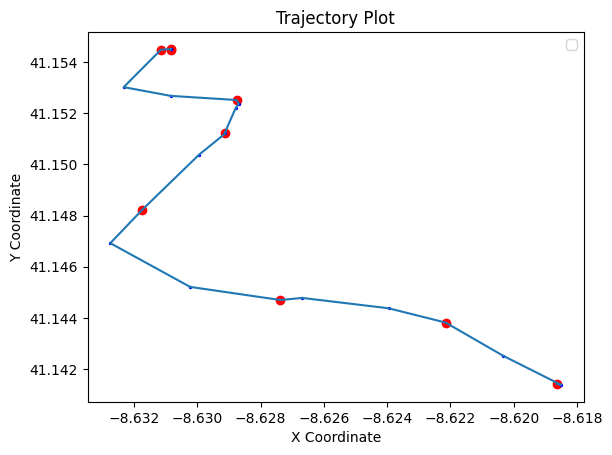

In [12]:
partitioned_trajectory, mask = traclus_partition(trajectory, epsilon)
vis_traj(trajectory, mask)

# Trajectory Generation

In [13]:
import numpy as np


def generate_angle(angle_dist=None):
    """
    从给定的角度分布中随机选择一个角度

    参数:
    angle_dist (list): 轨迹角度的分布，长度为 360 的序列

    返回:
    float: 随机选择的角度（弧度制）
    """
    if angle_dist is None:
        angles = np.arange(-180, 180)
        angle_dist = np.exp(-(angles**2) / (2 * 10**2))  # 标准差为 10 度的高斯分布
        angle_dist /= angle_dist.sum()  # 归一化

    angle = np.random.choice(np.arange(-180, 180), p=angle_dist)
    return np.radians(angle)


def generate_trajectory(gap, gap_variance, angle_dist=None, length=100, scaling=100):
    """
    生成轨迹数据

    参数:
    gap (float): 生成的轨迹中连续两点之间的欧氏距离的平均值
    gap_variance (float): 生成的轨迹中连续两点之间的欧氏距离的方差
    angle_dist (list, 可选): 轨迹角度的分布，长度为 360 的序列，默认为以 0 度为中心的高斯分布
    length (int, 可选): 生成点的数量，默认为 100

    返回:
    list: 生成的轨迹数据，每个元素为一个二维坐标 (x, y)
    """

    # 初始化轨迹，起点为 (0, 0)
    trajectory = [(0, 0)]
    current_x, current_y = 0, 0

    # 生成第一个点到第二个点的初始角度
    initial_angle = np.random.uniform(-np.pi, np.pi)
    dist = np.random.normal(gap, np.sqrt(gap_variance))
    next_x = current_x + dist * np.cos(initial_angle) / scaling
    next_y = current_y + dist * np.sin(initial_angle) / scaling
    trajectory.append((next_x, next_y))

    for _ in range(length - 2):
        # 生成连续两点之间的距离，服从正态分布
        dist = np.random.normal(gap, np.sqrt(gap_variance))

        # 获取当前线段和上一线段的夹角
        prev_x, prev_y = trajectory[-2]
        current_x, current_y = trajectory[-1]
        # 计算上一线段的角度
        prev_angle = np.arctan2(current_y - prev_y, current_x - prev_x)

        # 从角度分布中随机选择一个角度变化量
        angle_change_rad = generate_angle(angle_dist)

        # 计算下一段轨迹的角度
        next_angle = prev_angle + angle_change_rad

        # 计算下一个点的坐标
        next_x = current_x + dist * np.cos(next_angle) / scaling
        next_y = current_y + dist * np.sin(next_angle) / scaling

        # 将下一个点添加到轨迹中
        trajectory.append((next_x, next_y))

    return trajectory



# Cut Labeling

C:\Users\A1495\AppData\Local\Temp\ipykernel_62500\2564276038.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


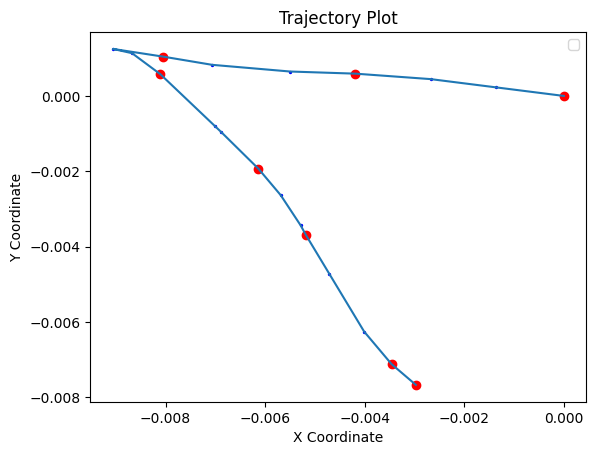

In [14]:

# 测试 generate_trajectory 函数
gap = 1
gap_variance = 0.25
length = 20
trajectory = generate_trajectory(gap, gap_variance, length=length, scaling=1000)
compressed_trajectory, mask = traclus_partition(trajectory)
vis_traj(trajectory, mask)

# Bi-LSTM

In [15]:
import torch
import torch.nn as nn
import numpy as np


# 定义 Bi - LSTM 模型
class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(BiLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            input_size, hidden_size, num_layers, batch_first=True, bidirectional=True
        )
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        # 初始化隐藏状态和细胞状态
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)

        # 前向传播 LSTM
        out, _ = self.lstm(x, (h0, c0))

        # 全连接层
        out = self.fc(out)
        out = torch.sigmoid(out)
        return out


# 生成一些示例轨迹数据
def generate_sample_trajectories(num_trajectories, min_length, max_length):
    trajectories = []

    gap = 1
    gap_variance = 0.25
    for _ in range(num_trajectories):
        length = np.random.randint(min_length, max_length + 1)
        trajectory = generate_trajectory(gap, gap_variance, length=length, scaling=1000)
        trajectories.append(trajectory)
    return trajectories


# 训练函数
def train_model(model, trajectories, partition_func, num_epochs=100, learning_rate=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        total_loss = 0
        for trajectory in trajectories:
            # 转换为张量并移动到设备上
            inputs = (
                torch.tensor(trajectory, dtype=torch.float32).unsqueeze(0).to(device)
            )
            _, labels = partition_func(trajectory)
            labels = (
                torch.tensor(labels, dtype=torch.float32)
                .unsqueeze(0)
                .unsqueeze(-1)
                .to(device)
            )

            # 前向传播
            outputs = model(inputs)

            # 去掉第一个和最后一个点
            outputs = outputs[:, 1:-1, :]
            labels = labels[:, 1:-1, :]

            loss = criterion(outputs, labels)

            # 反向传播和优化
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        if (epoch + 1) % 10 == 0:
            print(
                f"Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / len(trajectories):.4f}"
            )


# 预测函数
def predict(model, trajectory):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    # 转换为张量并移动到设备上
    inputs = torch.tensor(trajectory, dtype=torch.float32).unsqueeze(0).to(device)
    outputs = model(inputs)
    predictions = (outputs > 0.5).squeeze().cpu().tolist()
    predictions[0] = True
    predictions[-1] = True
    return predictions

In [16]:
# 生成示例轨迹数据
trajectories = generate_sample_trajectories(num_trajectories=100, min_length=10, max_length=20)

# 初始化模型
input_size = 2  # 每个轨迹点是二维的 (x, y)
hidden_size = 16
num_layers = 6
output_size = 1
model = BiLSTMModel(input_size, hidden_size, num_layers, output_size)

# 训练模型
train_model(model, trajectories, partition_func=traclus_partition)

Epoch [10/100], Loss: 0.0576
Epoch [20/100], Loss: 0.0559
Epoch [30/100], Loss: 0.0554
Epoch [40/100], Loss: 0.0552
Epoch [50/100], Loss: 0.0549
Epoch [60/100], Loss: 0.0548
Epoch [70/100], Loss: 0.0544
Epoch [80/100], Loss: 0.0545
Epoch [90/100], Loss: 0.0534
Epoch [100/100], Loss: 0.0533


In [ ]:
from trajlib.data_processing.data_reader import read_porto_csv
from trajlib.data_processing.utils.data_definition import TrajectoryData

all_traj_data = read_porto_csv(r"D:\codes\TrajMM\resource\dataset\Porto\porto_sample.csv")

traj_dict = all_traj_data.cal_all_trajs(attrs=['point_id', 'lon', 'lat'])
trajectories = []
for traj_id, info in traj_dict.items():
    trajectory = [(lon, lat) for lon, lat in zip(info['lon'], info['lat'])]
    trajectories.append(trajectory)


1000it [00:00, 4648.88it/s]


[[(-8.618643, 41.141412), (-8.618499, 41.141376), (-8.620326, 41.14251), (-8.622153, 41.143815), (-8.623953, 41.144373), (-8.62668, 41.144778), (-8.627373, 41.144697), (-8.630226, 41.14521), (-8.632746, 41.14692), (-8.631738, 41.148225), (-8.629938, 41.150385), (-8.62911, 41.151213), (-8.629128, 41.15124), (-8.628786, 41.152203), (-8.628687, 41.152374), (-8.628759, 41.152518), (-8.630838, 41.15268), (-8.632323, 41.153022), (-8.631144, 41.154489), (-8.630829, 41.154507), (-8.630829, 41.154516), (-8.630829, 41.154498), (-8.630838, 41.154489)], [(-8.639847, 41.159826), (-8.640351, 41.159871), (-8.642196, 41.160114), (-8.644455, 41.160492), (-8.646921, 41.160951), (-8.649999, 41.161491), (-8.653167, 41.162031), (-8.656434, 41.16258), (-8.660178, 41.163192), (-8.663112, 41.163687), (-8.666235, 41.1642), (-8.669169, 41.164704), (-8.670852, 41.165136), (-8.670942, 41.166576), (-8.66961, 41.167962), (-8.668098, 41.168988), (-8.66664, 41.170005), (-8.665767, 41.170635), (-8.66574, 41.170671)], 

C:\Users\A1495\AppData\Local\Temp\ipykernel_41116\2564276038.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


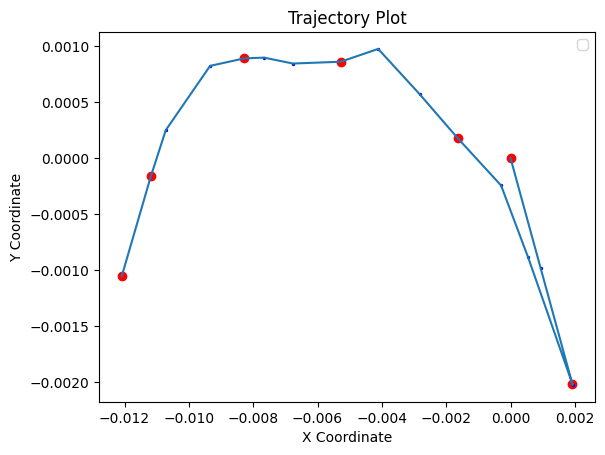

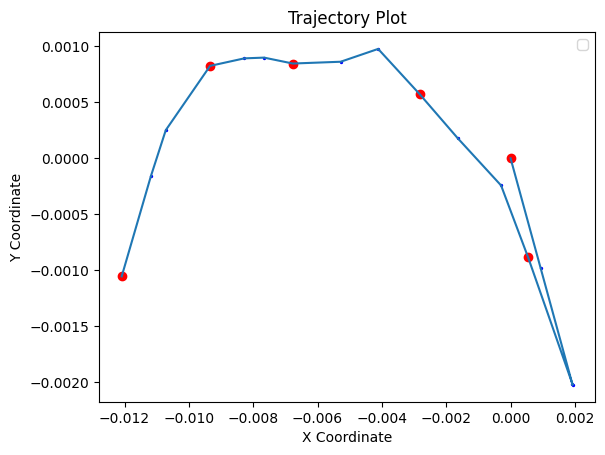

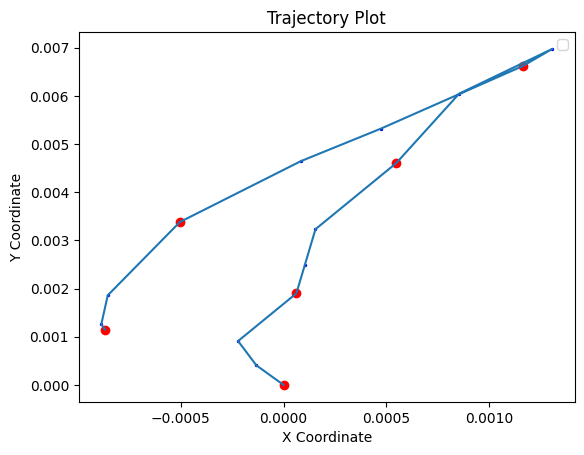

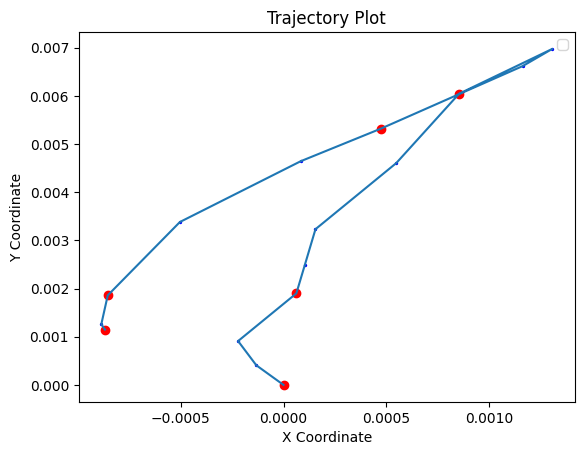

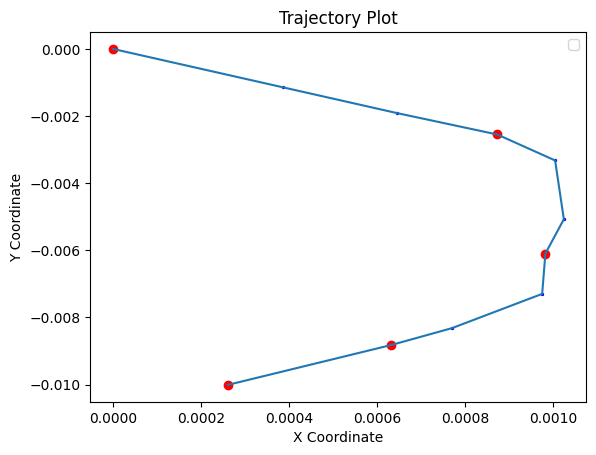

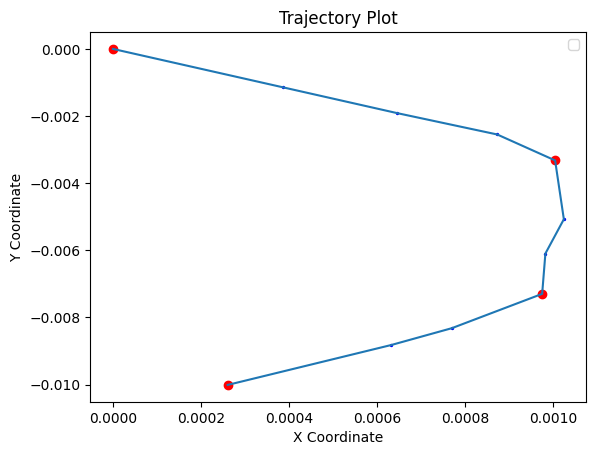

3

In [84]:
def evaluate_trajectory_partition(num_trajectories, model):
    """
    Evaluate the trajectory partition model by comparing predicted and true partitions.

    Args:
        num_trajectories (int): The number of test trajectories to generate.
        model: The trained model used for prediction.

    Returns:
        int: The number of trajectories with inconsistent partitions.
    """
    inconsistent_count = 0
    inconsistent_trajectories = []

    for i in range(num_trajectories):
        # Generate a test trajectory
        test_trajectory = generate_sample_trajectories(num_trajectories=1, min_length=10, max_length=20)[0]
        
        # Predict the partition
        predictions = predict(model, test_trajectory)
        
        # Get the true partition
        _, mask = traclus_partition(test_trajectory)
        
        # Check if the predicted and true partitions are consistent
        if not np.array_equal(predictions, mask):
            inconsistent_count += 1
            inconsistent_trajectories.append((test_trajectory, predictions, mask))
    
    # Visualize the inconsistent trajectories
    for traj, pred, true in inconsistent_trajectories:
        vis_traj(traj, pred)
        vis_traj(traj, true)
    
    return inconsistent_count

# evaluate_trajectory_partition(100, model)


In [4]:
import pandas as pd
from fedtraj.config import Config

Config.post_value_updates()
traj_data = pd.read_pickle(Config.dataset_file)
traj_data

,trajlen,wgs_seq,merc_seq
0,23,"[[-8.618643, 41.141412], [-8.618499, 41.141376...","[[-959422.9500890118, 5033222.330434652], [-95..."
1,19,"[[-8.639847, 41.159826], [-8.640351, 41.159871...","[[-961783.3685717921, 5035944.621581613], [-96..."
2,65,"[[-8.612964, 41.140359], [-8.613378, 41.14035]...","[[-958790.7667007967, 5033066.680001558], [-95..."
3,43,"[[-8.574678, 41.151951], [-8.574705, 41.151942...","[[-954528.7886762854, 5034780.3028089935], [-9..."
4,29,"[[-8.645994, 41.18049], [-8.645949, 41.180517]...","[[-962467.6494816985, 5039000.459391122], [-96..."
...,...,...,...
814,32,"[[-8.596971, 41.1507], [-8.596953, 41.150727],...","[[-957010.43408454, 5034595.35532951], [-95700..."
815,65,"[[-8.639829, 41.159718], [-8.639856, 41.159709...","[[-961781.3648209581, 5035928.652835235], [-96..."
816,64,"[[-8.611398, 41.143113], [-8.610714, 41.143167...","[[-958616.4403782145, 5033473.77102891], [-958..."
817,51,"[[-8.585775, 41.148531], [-8.58582, 41.14863],...","[[-955764.1010656185, 5034274.699357971], [-95..."
